# Bayesian analysis of the empirical saturation point (refactored version)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Performing Bayesian linear regression on EFT predictions (Coester Band)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 41 seconds.


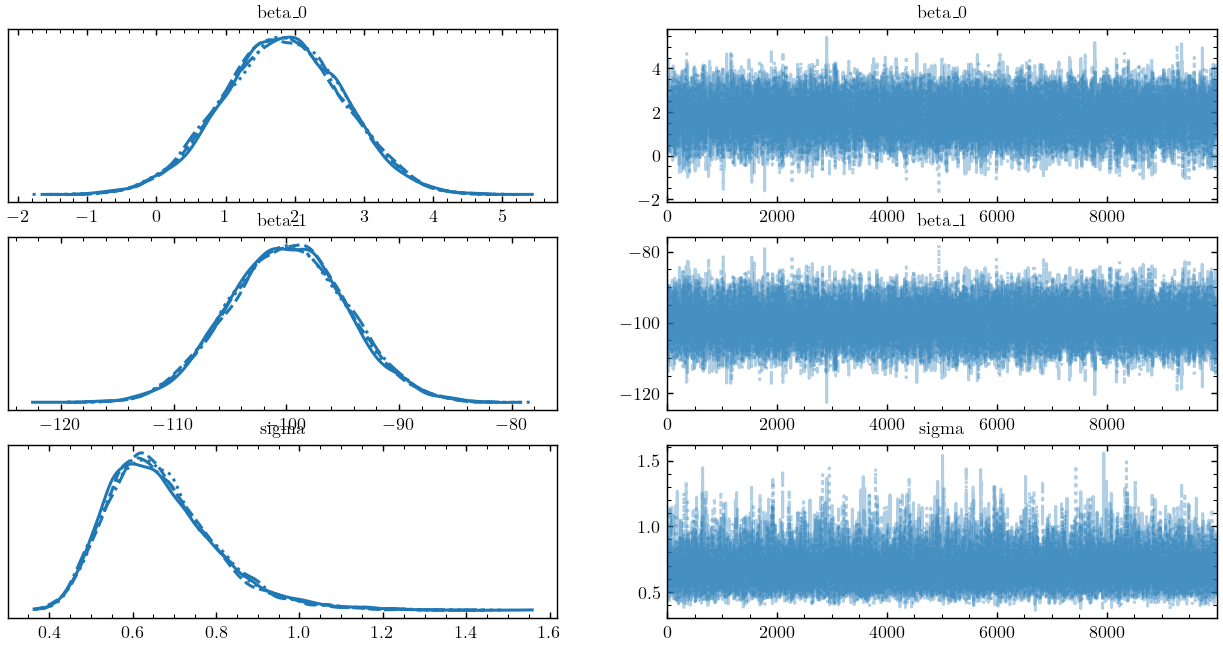

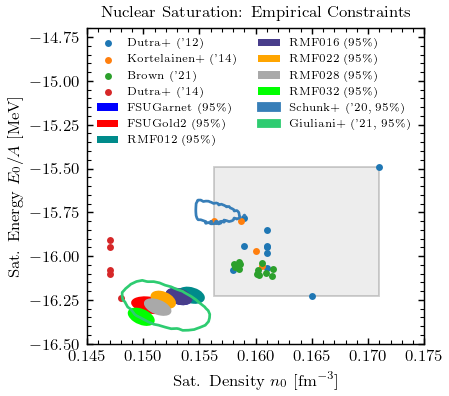

In [2]:
from modules.SaturationAnalysis import SaturationAnalysis
analysis = SaturationAnalysis()
analysis.plot_constraints(eft=False, eft_conf_level=0.95)

## Priors

Let's take a look at the priors used in this work. They can be specified in the file `modules/priors.py`.

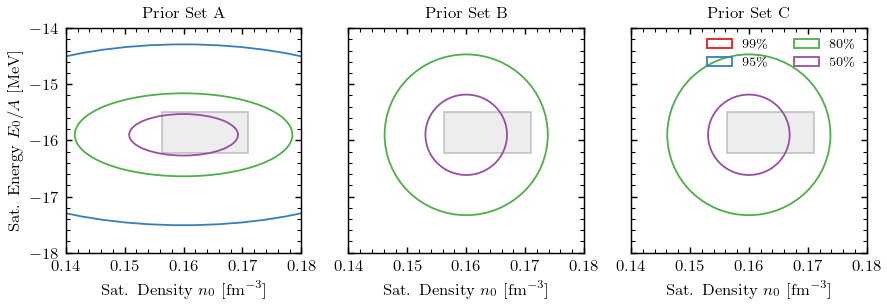

In [3]:
from modules.SaturationAnalysis import visualize_priors
from modules.priors import *
fig, axs = visualize_priors(used_prior_sets)
fig.savefig("prior_sets.pdf")

We use an uninformed prior (left) and an informed prior (right) and something in between (center panel) to investigate the prior sensitivity of our Bayesian inference.

## Saturation box in Drischler et al. (2016)

### Apply our statistical model directly

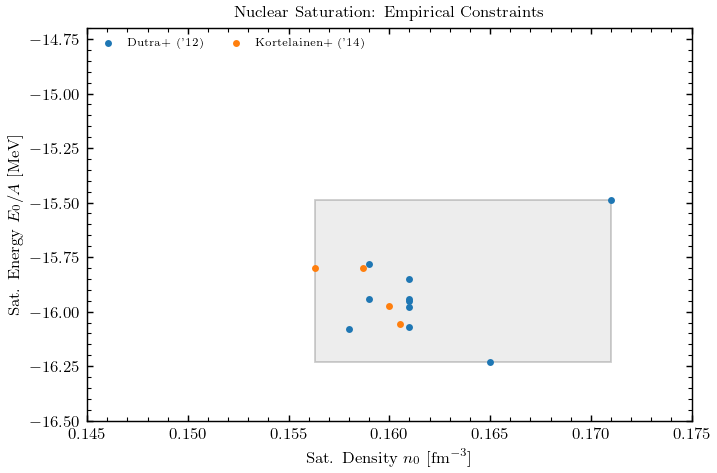

In [4]:
from modules.SaturationAnalysis import drischler_satbox
drischler_satbox.plot(plot_box_estimate=True)

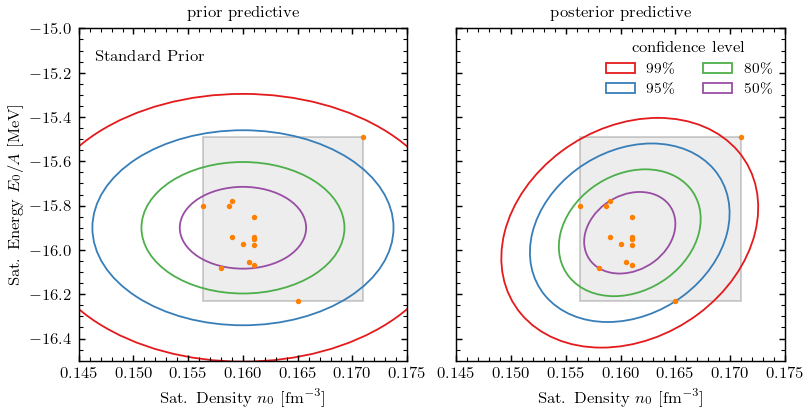

In [5]:
from modules.StatisticalModel import StatisticalModel
model = StatisticalModel(data=drischler_satbox.data_frame)
fig, _ = model.plot_predictives(validate=False)
fig.savefig("analysis_satbox_2016.pdf")

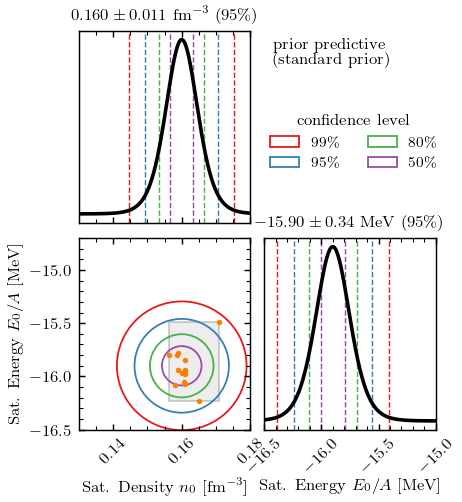

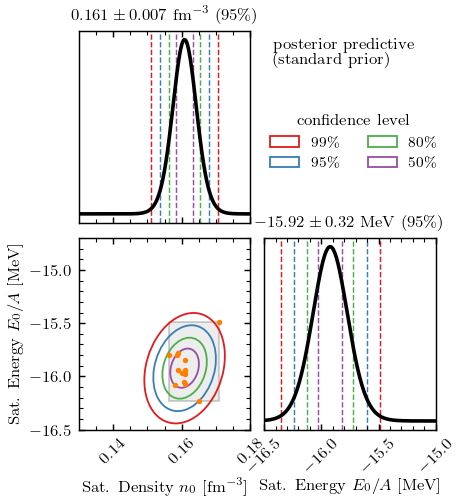

In [6]:
ret = model.plot_predictives_corner()
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("pdf/corner_plot.pdf")
for elem in ret:
    fig, axs = elem
    pdf.savefig(fig)
pdf.close()

Generting the corner plot did not require any sampling of the distribution functions. Only (semi-)analytic calculations. Let's check our implementation brute-force using sampling:

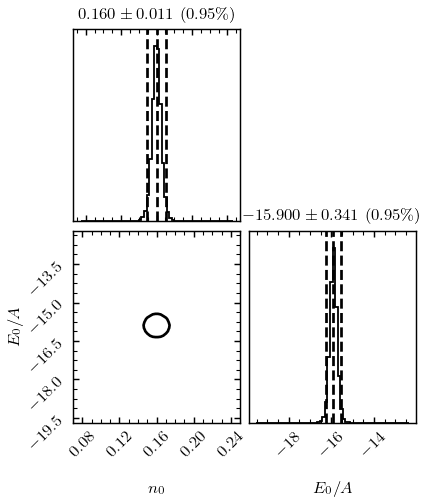

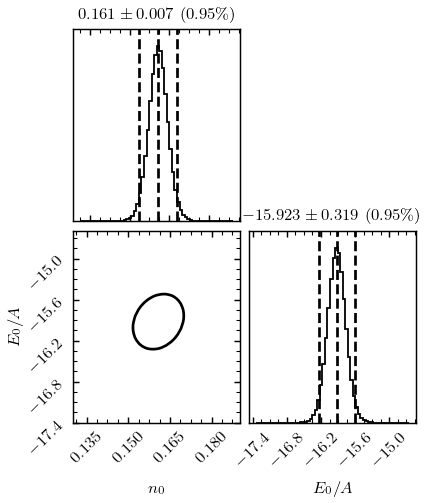

In [7]:
ret = model.plot_predictives_corner_bf()
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("pdf/corner_plot_bf.pdf")
for elem in ret:
    fig, axs = elem
    pdf.savefig(fig)
pdf.close()

The results match. However, the Python package `corner` has a known bug. The percentiles in the titles are always the default ones. We have fixed the issue by computing the percentiles separately. The percentiles above correspond to the 95% confidence level.

In [8]:
model.posterior_params

{'kappa': 15,
 'nu': 24,
 'mu': array([  0.16083667, -15.92253333]),
 'Psi': array([[2.62060933e-04, 2.55211333e-03],
        [2.55211333e-03, 5.11603733e-01]])}

### Alternative: use a single Monte Carlo step

MC sampling: 100%|██████████| 1/1 [01:09<00:00, 69.64s/it]


Results written to './pdf/drischler-satbox.pdf'


{'mu': array([  0.16083721, -15.92252508]),
 'Psi': array([[1.21674284e-05, 1.18561936e-04],
        [1.18561936e-04, 2.37519061e-02]]),
 'df': 23.0}

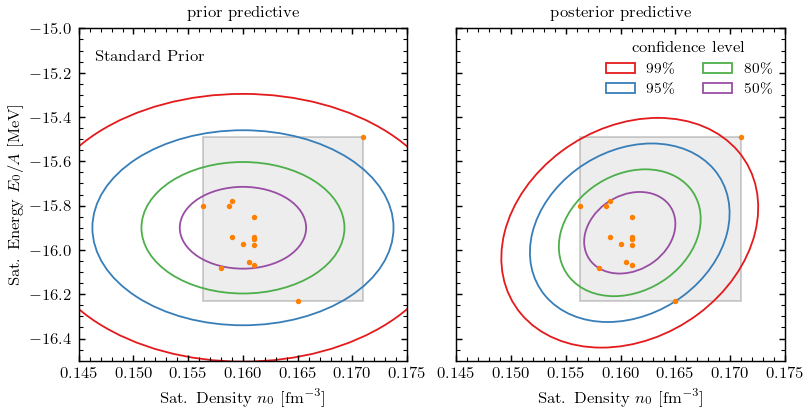

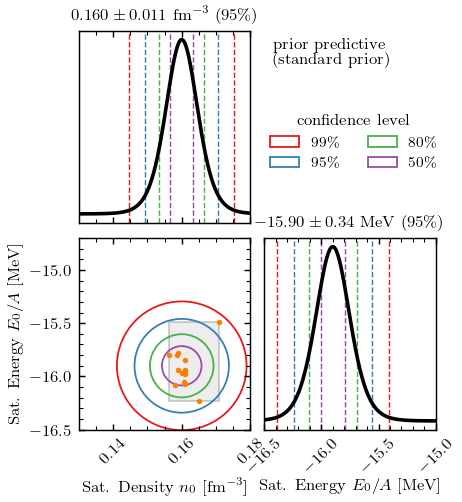

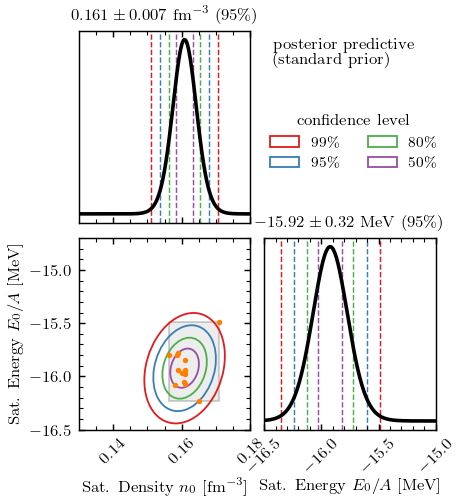

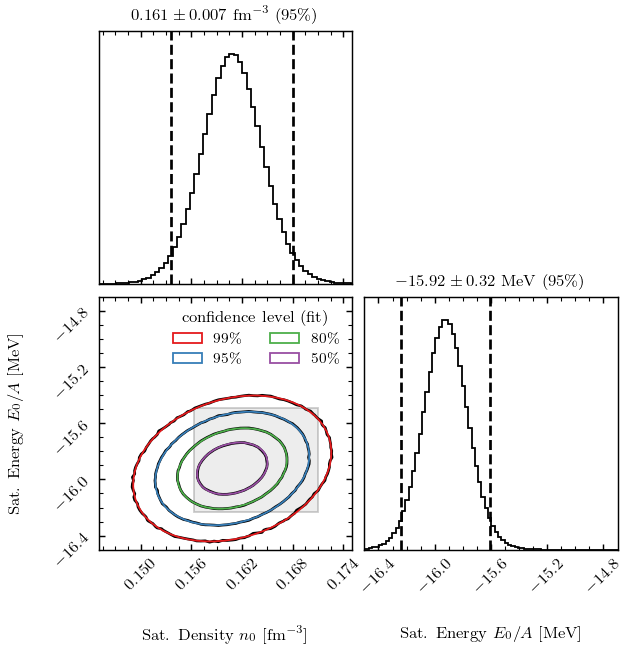

In [22]:
from modules.DataSets import DataSetSampleConfig, Scenario
from modules.SaturationAnalysis import drischler_satbox
from modules.priors import standard_prior_params
scenarioX = Scenario(
    label="Drischler Satbox",
    configs=[DataSetSampleConfig(data_set=drischler_satbox)]
)

analysis.multiverse(
    scenarioX,
    num_realizations=1,
    prior_params=standard_prior_params,
    debug=False,
    plot_fitted_conf_regions=True
)

## Hierarchical model

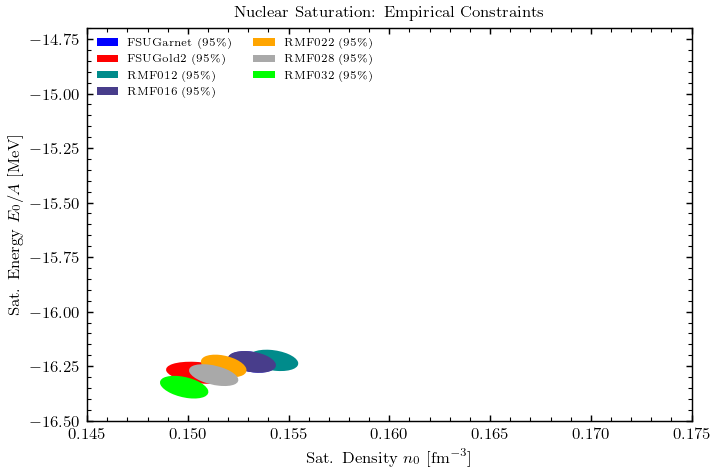

In [23]:
from modules.DataSets import DataSetSampleConfig, Scenario
from modules.SaturationAnalysis import DEFAULT_DFT_CONSTRAINTS as dft_constraints
scenario1 = Scenario(
    label="FSU-only",
    configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"])]
)

scenario2 = Scenario(
    label="FSU+Schunck-only",
    configs=[
        DataSetSampleConfig(
            data_set=dft_constraints["FSU"]
        ),
        DataSetSampleConfig(
            data_set=dft_constraints["Schunck"]
        )
    ]
)
scenario3 = Scenario(
    label="all",
    configs=[
        DataSetSampleConfig(
            data_set=dft_constraints[lbl]
        ) for lbl in dft_constraints.keys()
    ]
)
scenario4 = Scenario(
    label="Giuliani+Schunck-only",
    configs=[DataSetSampleConfig(
        data_set=dft_constraints["Giuliani"]
    ),
        DataSetSampleConfig(
            data_set=dft_constraints["Schunck"]
        )
    ]
)
scenario1.configs[0].data_set.plot()

In [ ]:
analysis.multiverse(scenarioX, prior_params=standard_prior_params)

In [ ]:
analysis.multiverse(scenario2)

In [ ]:
analysis.multiverse(scenario3)

In [ ]:
analysis.multiverse(scenario4)

In [ ]:
analysis.plot_individual_models()